<a href="https://colab.research.google.com/github/gvarnavi/generative-art-iap/blob/master/01.14-Tuesday/04_mathematical-fractals_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mathematical Fractals
"A fractal is a way of seeing infinity." ~ *Benoit Mandelbrot*

## Logistic map
Maps parameterized by a discrete-time parameter often take the form of iterated functions. One prototypical example is the **logistic map**, which is a simple one-dimensional map given by:

> $ x_{n+1} = rx_n(1 - x_n) $

where $r$ is a constant parameter. To identify the unique properties of this system, we want to visualize how the map evolves with successive iterations as a function of the parameter $r$, and to determine the nature of the state toward which the system tends after many iterations.

We start by defining some library imports we will need throughout this notebook.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from matplotlib.colors import ListedColormap
from scipy import ndimage
from scipy.optimize import root
from numba import jit
from google.colab import files

Next, we want to define a function ```logistic``` which takes the parameter $r$ and current state $x$ and computes the next iterate of the logistic map.

In [0]:
def logistic(x, r):
    ''' Compute the next iterate of the logistic map. '''
    return r*x*(1 - x)

Now, let's create a function ```iter_logistic``` to perform the logistic map sequentially over many iterations and record the path taken. In particular, we will represent $x_n$ on the x-axis and $x_{n+1}$ on the y-axis. Given a starting x, we can evaluate $y =$ ```logistic```$(x, r)$ and record the value $(x, y)$; then, we update our initial state by sending $y \rightarrow x$ and again record $(x, y)$. Then repeat the process, keeping track of $(x, y)$ at each step. The function returns an array of all the recorded points after a specified number of iterations $N$.

In [0]:
def iter_logistic(x0, r, N):
    ''' Evaluate logistic map sequentially over N iterations
        and return the resulting path as an array of line segments.
        inputs:
          x0 - initial value
          r  - constant parameter
          N  - number of iterations
        outputs:
          segments - array of traversed points
    '''
    segments = np.zeros((2*N, 2))         # array to store all (x,y) pairs
    x, y = x0, 0                          # initialization
    segments[0,:] = [x, y]                # store initial condition

    for i in range(1,N):
        y = logistic(x, r)                # compute next iterate
        segments[2*i-1,:] = [x, y]
        x = y                             # set next initial condition
        segments[2*i,:] = [x, y]
    y = logistic(x, r)
    segments[-1,:] = [x, y]
    return segments

The type of procedure outlined above generates what is known as a **cobweb plot**, so let's make a function ```cobweb_plot``` to visualize the evolution of the map over several iterations.

In [0]:
def cobweb_plot(x0, r, N):
    ''' Plot the trajectory of mapping the logistic function sequentially over 
        N iterations.
        inputs:
          x0 - initial value
          r  - constant parameter
          N  - number of iterations
        outputs:
          f, ax - figure and axis objects of resulting plot
    '''
    # initialize figure axes
    f = plt.figure(figsize=(7,7))
    ax = f.add_subplot()
    ax.grid(False)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$\mathrm{\mathsf{x_n}}$', fontsize=14)
    ax.set_ylabel('$\mathrm{\mathsf{x_{n+1}}}$', fontsize=14)
    ax.tick_params(labelsize=14)

    # plot logistic map
    x = np.linspace(0,1,100)
    y = logistic(x, r)
    ax.plot(x, y, linewidth=1.5, color='k')

    # plot dashed line y = x
    ax.plot(x, x, linestyle='dashed', color='k')

    # plot iterated path initialized at x0 over N iterations
    segments = iter_logistic(x0, r, N)
    ax.plot(segments[:,0], segments[:,1], linewidth=1.5, color='darkslateblue')
    return f, ax

Try it below for different values of the parameter $r$. Executing the cell below will create a slider you can use to change $r$ interactively. Note the kinds of orbits toward which the system evolves for different $r$.

In [0]:
r_slider = widgets.FloatSlider(value=2.4, min=0, max=4., step=0.001, description='r:', readout_format='.3f')
@widgets.interact(r = r_slider)
def cobweb_slider(r=2.4):
    cobweb_plot(0.2, r, 50)

interactive(children=(FloatSlider(value=2.4, description='r:', max=4.0, readout_format='.3f', step=0.001), Out…

To plot outside of the widget, you can simply run the following code and manually change the value $r$ to see different examples:

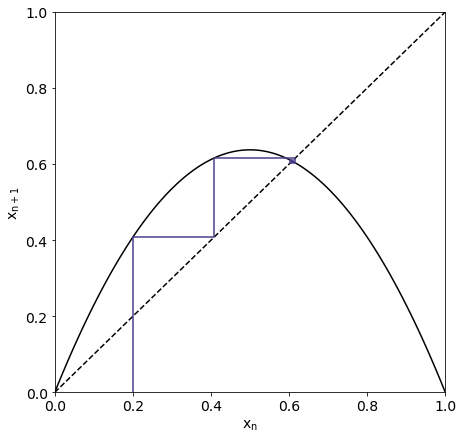

In [0]:
r = 2.55
cobweb_plot(0.2, r, 50)
plt.show()

We can see that in certain parameter intervals, the map settles into periodic orbits about one or more fixed points, while in other cases, it behaves chaotically. These parameter intervals and the corresponding orbits can be visualized using an orbit diagram, which is a plot of the stable orbits $x$ at a particular value of the parameter $r$. Let's write a function ```orbit_diagram``` to visualize.

In [0]:
def orbit_diagram():
    ''' Plot of the stable orbits of the logistic map over a range of
        parameter values r.
    '''
    f = plt.figure(figsize=(8,7))
    ax = f.add_subplot()
    ax.set_xlabel('r', fontsize=14)
    ax.set_ylabel('x', fontsize=14)
    ax.tick_params(labelsize=14)

    rmin, rmax = 2.4, 4.                   # min and max values of r to plot
                                           # (note: for r<1, only stable orbit is at 0)
    nr = 10000                             # number of r values to vary
    r = np.linspace(rmin, rmax, nr)        # parameter space 
    
    x = 1e-6*np.ones(nr)                   # initial x for each parameter
    N = 1000                               # number of iterations

    for i in range(N):
        x = logistic(x, r)
        #  discard transient behavior by plotting only the final 100 iterations
        if i >= (N - 100):
            ax.plot(r, x, ',', color='darkslateblue', alpha=.25)
        
    ax.set_xlim([rmin, rmax])
    return f, ax

Let's plot.

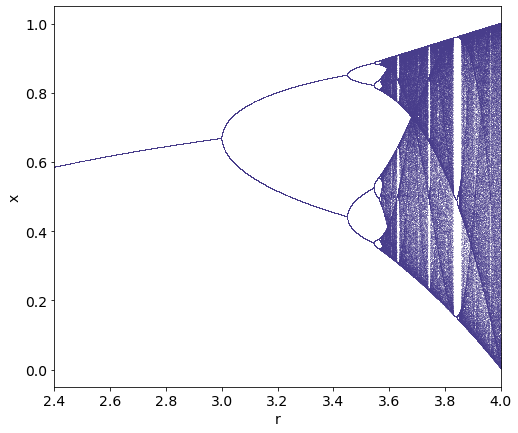

In [0]:
orbit_diagram()
plt.show()

Note the bifurcations in the orbit diagram at values of $r$ where "period doubling" occurs. The orbit diagram is in fact fractal; if we zoom in, the diagram looks self-similar. This is a clue that chaotic maps can actually be used to generate fractals.



Do you notice some curvy shadows appearing in the orbit diagram image? We know these are not continuous lines since we constructed our plot by plotting individual points, but amazingly they appear as such! These shadowy lines are in fact expressible in terms of polynomial curves known as **Q-curves**, and they are an amazing way to approximate the orbit diagram we found above. The basic principle is to recursively call our logistic function many times for a range of the parameter values $r$ - the number of recursive calls equals the number of Q-curves we will draw. This is controlled by the input parameter called ```order``` in the code below. Below, we define a function ```nested_logistic``` that recursively calls our logistic map function created above. Then, the function ```q_curves``` will plot these polynomials.

In [0]:
def nested_logistic(i, x, r):
    if i == 1:
        return logistic(x, r)
    else:
      return nested_logistic(i-1, logistic(x, r), r)

def q_curves(order):
    ''' Plot a continuous polynomial approximation of the orbit diagram.
    '''
    f = plt.figure(figsize=(9,7))
    ax = f.add_subplot()
    ax.set_xlabel('r', fontsize=14)
    ax.set_ylabel('x', fontsize=14)
    ax.tick_params(labelsize=14)

    rmin, rmax = 2.4, 4.                   # min and max values of r to plot
    nr = 1000                              # number of r values to vary
    r = np.linspace(rmin, rmax, nr)        # parameter space 
    Q = np.zeros((len(r), order))          # array to store Q-curves

    # find a single non-zero fixed point
    x0 = root(logistic, 0.5, args=(rmin,)).x

    for i, ri in enumerate(r):
        for j in range(1, order+1):
            Q[i,j-1] = nested_logistic(j, x0, ri)
    
    for j in range(order):
        ax.plot(r, Q[:,j], linewidth=0.5, color='darkslateblue')
    ax.set_xlim([rmin, rmax])
    return f, ax

Try varying the input value to ```q_curves```. As we increase the number of Q-curves to draw, our approximation becomes better and better.

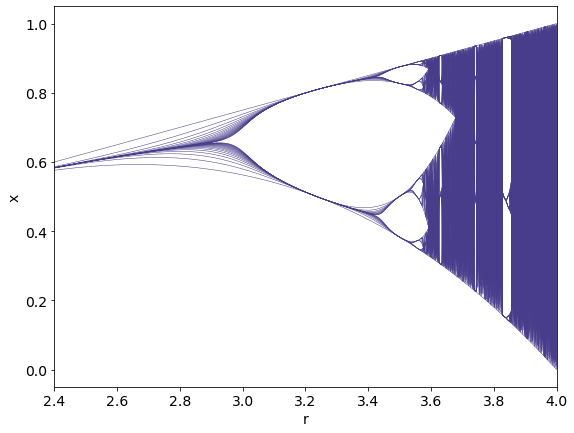

In [103]:
f, ax = q_curves(40)
plt.show()

Because this plot is comprised of continuous lines, it is much easier to make vector graphics with it. Run the two cells below to save and then download this image if desired. (Note: If you are working from a local copy of this notebook, then you do not need to do the download step; the saved image should simply appear in the same directory as this notebook. If you are not running a local copy of the notebook, but are working in the Google Colaboratory environment, then you will need to download your image after saving it by executing the ```files.download``` command.)

In [0]:
f.savefig('orbit_diagram.svg')

In [0]:
files.download('orbit_diagram.svg')

## Julia set
The **Julia set** is the set of initial points whose orbits remain bounded under iterations of a given map. We will illustrate it using the quadratic Julia set as an example, which is the Julia set of the discrete two-dimensional map given by the family of complex quadratic polynomials:

> $ z_{n+1} = z_n^2 + c $

where $z_n$ and $c$ are both complex.

To start, we again want to define a function ```quadratic``` which takes as input the parameter $c$ and current state $z$ and computes the next iterate of the quadratic map.

In [0]:
@jit
def quadratic(z, c):
    ''' Compute the next iterate of the discrete quadratic map. '''
    return z**2 + c

To determine if a point is a member of the Julia set, we will create a function ```julia``` to iteratively call our map a specified number of times. If upon iteration, a point goes beyond some escape radius $R$, we will call that orbit unbounded and return the number of iterations it took to escape. If the point never escapes in the given number of steps, we will simply return the maximum number of iterations.

In [0]:
@jit
def julia(func, max_iters, z0, c, R):
    ''' Determine whether a point z0 belongs to the Julia set of a function
        given a maximum number of iterations max_iters.
        inputs:
          func - function of the iterative map (e.g. quadratic)
          max_iters - maximum number of iterations
          z0 - initial value
          c - constant parameter
          R - escape radius radius beyond which orbits are considered unbounded
        outputs:
          number of iterations required to escape (or max_iters if orbit
          remains bounded.)
    '''
    z = z0
    for i in range(1, max_iters):
        z = func(z, c)
        if np.abs(z) >= R:
            return i
    return max_iters

Finally, for visualization we want to record the number of iterations required for escape for many different points. Since our map is involves complex numbers, we can represent everything in a two-dimensional space. The function ```make_fractal``` populates a pre-initialized image space with the iteration numbers output by a given set function, such as ```julia```, for a given map function, such as ```quadratic```. The built-in function ```complex``` can be used to create a complex number given a real part $x$ and imaginary part $y$ as ```complex(x,y)```.

In [0]:
@jit
def make_fractal(set_func, map_func, image, max_iters, xr, yr, c, R):
    ''' For each image pixel with bounds given by xr and yr, compute the set
        set_func of the map map_func.
        inputs:
          set_func - function of the set to compute (e.g. julia)
          map_func - function of the iterative map (e.g. quadratic)
          image - empty 2D array in which to store image pixels
          max_iters - maximum number of iterations
          xr, yr - tuples specifying the image domain
          c - constant parameter
          R - escape radius radius beyond which orbits are considered unbounded
        outputs:
          image - 2D array populated with iterations needed to escape
    '''
    ny, nx = image.shape
    xmin, xmax = xr
    ymin, ymax = yr
    dx = (xmax - xmin)/nx
    dy = (ymax - ymin)/ny
    
    for i in range(nx):
        x = xmin + i*dx
        for j in range(ny):
            y = ymin + j*dy
            image[j,i] = set_func(map_func, max_iters, complex(x, y), c, R)
    return image

Now, all we need is to convert the iteration values to a color image. To do this, we define some helper functions ```make_figure``` and ```make_color_image``` to set up the figure and pick the colormap, and to convert an array of input values to an rgba image using the specified colormap.

Finally, we package all the necessary steps sequentially into a function we call ```plot_fractal```.

In [0]:
def make_figure():
    ''' Set up figure axes and colormap. '''
    f = plt.figure(figsize=(7,7))
    ax = f.add_subplot()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cmap_colors = plt.get_cmap('twilight').colors
    d = len(cmap_colors)
    cmap = ListedColormap(np.concatenate([cmap_colors[:d//2][::-1], 
                                          cmap_colors[:int(0.6*d)]]))
    return f, ax, cmap

def make_color_image(image, cmap):
    ''' Convert iteration values to rgba color array. '''
    ny, nx = image.shape
    color_image = np.zeros((ny, nx, 4), dtype=np.uint8)
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    color_image = cmap(image)
    return color_image

def plot_fractal(set_func, map_func, max_iters, xr, yr, c, R):
    ''' Plot the fractal image generated by the set set_func of map map_func.
        inputs:
          set_func - function of the set to compute (e.g. julia)
          map_func - function of the iterative map (e.g. quadratic)
          max_iters - maximum number of iterations
          xr, yr - tuples specifying the image domain
          c - constant parameter
          R - escape radius radius beyond which orbits are considered unbounded
        outputs:
          f, ax - figure and axis objects of resulting plot
    '''
    # initialize array
    nx = 1000
    ny = 1000
    image = np.zeros((ny, nx), dtype=np.uint8)

    # make fractal image
    make_fractal(set_func, map_func, image, max_iters, xr, yr, c, R)

    # set up figure and convert iteration values to a color image
    f, ax, cmap = make_figure()
    image = make_color_image(image, cmap)

    # smooth image a little
    image = np.flipud(ndimage.uniform_filter(image, size=(3,3,0)))

    # display image
    ax.imshow(image)
    return f, ax

Let's visualize the image formed by the Julia set. Play around with the different values of the constant $c$ given below.

In [0]:
@widgets.interact_manual(c = ['romanesco', 'paisley', 'snowflake', 'dendrite', 'galaxy', 'vortices'])
def quadratic_julia_dropdown(c='romanesco'):   
    # suggested parameter sets
    romanesco = complex(-0.4, 0.6)
    paisley = complex(0.285, 0.01)
    snowflake = complex(-0.70176, -0.3842)
    dendrite = complex(-0.835, -0.2321)
    galaxy = complex(-0.7269, 0.1889)
    vortices = complex(-0.8, 0.156)

    xr, yr = (-1.5, 1.5), (-1.5, 1.5)         # image domain
    plot_fractal(julia, quadratic, 1000, xr, yr, eval(c), 10)

Use the sliders to find some other interesting patterns.

In [0]:
Re_slider = widgets.FloatSlider(value=-0.4, min=-1., max=1., step=0.001, description='Re(c):', readout_format='.3f')
Im_slider = widgets.FloatSlider(value=0.6, min=-1., max=1., step=0.001, description='Im(c):', readout_format='.3f')

@widgets.interact_manual(Re = Re_slider, Im = Im_slider)
def quadratic_julia_slider(Re=-4., Im=0.6):
    xr, yr = (-1.5, 1.5), (-1.5, 1.5)         # image domain
    plot_fractal(julia, quadratic, 1000, xr, yr, complex(Re, Im), 10)

To simply plot a static image with a fixed set of parameters, you can run the following:

In [0]:
# manually enter the parameter values for Re, Im:
Re, Im = -0.4, 0.6

# plot the image
xr, yr = (-1.5, 1.5), (-1.5, 1.5)         # image domain
plot_fractal(julia, quadratic, 1000, xr, yr, complex(Re, Im), 10)
plt.show()

### Saving Figures

After we've found a good set of parameters, we can use the ```savefig``` command to save our figure following the syntax below. Make sure to change im_name to the desired image file name, and to change the parameter values to the ones you found! Afterward, we will run one more cell to download the image from the google colab files.

In [0]:
#*********************** change me **************************#
# input the name you want to give your image file as a string
im_name = 'my_image'

# enter the parameter values you found above as Re, Im:
Re, Im = -0.4, 0.6
#************************************************************#

# plot the image outside of the widget and retain the figure handle f
xr, yr = (-1.5, 1.5), (-1.5, 1.5)         # image domain
f, ax = plot_fractal(julia, quadratic, 1000, xr, yr, complex(Re, Im), 10)

# save image
f.savefig(im_name + '.png')

If you are working from a local copy of this notebook, the saved image should appear in the same directory as this notebook. If you are not running a local copy of the notebook, but are working in the Google Colaboratory environment, you will need to download your image after saving it by executing the following command:

In [0]:
# download image
files.download(im_name + '.png')

The image should then download into your Downloads folder.

Now let's animate how the fractal patterns evolve as we gradually tune $c$. We'll need to import a few more libraries for the animation.

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML

To make the movie, we'll want to build up a stack of fractal images with as many frames as different parameters. This is handled by ```make_fractal_stack```.

In [0]:
def make_fractal_stack(set_func, map_func, max_iters, xr, yr, cs, R, n_images):
    ''' For each image pixel with bounds given by xr and yr, compute the set
        set_func of the map map_func, for a set of n_images.
        inputs:
          set_func - function of the set to compute (e.g. julia)
          map_func - function of the iterative map (e.g. quadratic)
          max_iters - maximum number of iterations
          xr, yr - tuples specifying the image domain
          cs - array of constant parameters to vary
          R - escape radius radius beyond which orbits are considered unbounded
          n_images - number of images 
        outputs:
          images - 3D stack of 2D arrays populated with iterations needed to
          escape
    '''
    # initialize array
    nx = 1000
    ny = 1000
    images = np.zeros((ny, nx, n_images), dtype=np.uint8)

    print('generating images', end='', flush=True)
    for i, c in enumerate(cs):
        make_fractal(set_func, map_func, images[:,:,i], max_iters, xr, yr, c, R)
        
        # track our progress
        if i%2==0:
            print('.', end='', flush=True)
    print(' done!')

    # standardize and smooth images a little
    images = (images - np.min(images))/(np.max(images) - np.min(images))
    images = np.flipud(ndimage.uniform_filter(images, size=(3,3,0)))

    return images

Now we can create a movie of the quadratic Julia set evolving as we sweep $c$ over the range $c = 0.7885e^{i \theta}$, with $\theta$ running from $0$ to $2 \pi$.

In [0]:
# sweep through a range of the constant c parameterized by T
n_images = 100                            # number of movie frames
T = np.linspace(0, 2*np.pi, n_images)
cs = [complex(0.7885*np.cos(t), 0.7885*np.sin(t)) for t in T]

# make stack of images
xr, yr = (-1.5, 1.5), (-1.5, 1.5)         # image domain
images = make_fractal_stack(julia, quadratic, 50, xr, yr, cs, 10, n_images)

# set up figure axes and initialize color image array
f, ax, cmap = make_figure()
image = np.zeros((images.shape[0], images.shape[1], 4), dtype=np.uint8)
im = ax.imshow(image)

# initialization function for animation
def init():
    im.set_data(cmap(images[:,:,0]))
    return im,

# animation
spf = 2             # time steps per frame
def animate(i):
    im.set_data(cmap(images[:,:,i+1]))
    return im,

print('creating movie')
# create animation
ani = animation.FuncAnimation(f, animate, init_func=init, frames=n_images-1, interval=100, blit=True)
plt.close(f)

# display animation
HTML(ani.to_html5_video())

## Mandelbrot set
A complement to the Julia set is the **Mandelbrot set**, which is the parameter space of possible $c$ values for which the quadratic map remains bounded when initialized at $z_0 = 0 + 0i$. Due to their similarity, we can can repurpose all our existing code when simulating the Mandelbrot set if we define our function ```mandel``` identially to ```julia```, but reverse the order of the arguments $z_0$ and $c$ in the function inputs. Then, we just need to remember to pass $z_0 = 0 + 0i$ for the initial value.

In [0]:
@jit
def mandel(func, max_iters, c, z0, R):
    ''' Determine whether a point c belongs to the Mandelbrot set of a function
        given a maximum number of iterations max_iters.
        inputs:
          func - function of the iterative map (e.g. quadratic)
          max_iters - maximum number of iterations
          c - constant parameter
          z0 - initial value; formally, one should input z0 = complex(0,0).
          R - escape radius radius beyond which orbits are considered unbounded
        outputs:
          number of iterations required to escape (or max_iters if orbit
          remains bounded.)
    '''
    z = z0
    for i in range(1,max_iters):
        z = func(z, c)
        if np.abs(z) >= R:
            return i
    return max_iters

Now we can easily visualize the Mandelbrot set reusing the ```quadratic``` and ```make_fractal``` functions defined earlier.

In [0]:
xr, yr = (-1.5, 1.), (-1.25, 1.25)        # image domain
plot_fractal(mandel, quadratic, 1000, xr, yr, complex(0,0), 10)
plt.show()

### Blowing in the Wind

What happens if we make the initial point $z_0$ non-zero and compute its Mandelbrot set? The code below makes a video that sweeps $z_0$ along the diagonal from $0+0i$ to $1+i$. The Mandelbrot set looks like it's blowing away in the wind!

In [0]:
# sweep through a range of the constant c
n_images = 100                            # number of movie frames
T = np.linspace(0, 2*np.pi, n_images)
cs = [complex(i, i) for i in np.linspace(0, 1, n_images)]

# make stack of images
xr, yr = (-1.5, 1.), (-1.25, 1.25)         # image domain
images = make_fractal_stack(mandel, quadratic, 50, xr, yr, cs, 10, n_images)

# set up figure axes and initialize color image array
f, ax, cmap = make_figure()
image = np.zeros((images.shape[0], images.shape[1], 4), dtype=np.uint8)
im = ax.imshow(image)

# initialization function for animation
def init():
    im.set_data(cmap(images[:,:,0]))
    return im,

# animation
spf = 2             # time steps per frame
def animate(i):
    im.set_data(cmap(images[:,:,i+1]))
    return im,

print('creating movie')
# create animation
ani = animation.FuncAnimation(f, animate, init_func=init, frames=n_images-1, interval=100, blit=True)
plt.close(f)

# display animation
HTML(ani.to_html5_video())

The relationship between the Julia and Mandelbrot sets is summarized below.
![fractal summary](https://drive.google.com/uc?id=17YzZzGFOfLeXITCLqXcpBNh4TZLaU6IL)

## Examples Playground

Why not try and plot the Julia sets of other maps?
Let's try the function:

> $z_{n+1} = c\text{sin}(z_n)$

Defining the function map:

In [0]:
@jit
def sinusoid(z, c):
    return c*np.sin(z)

Let's plot. Play around with the image domain values to see more and more resolved features! Note: The more zoomed-in images may take a little longer to generate.

In [0]:
domain_slider = widgets.FloatSlider(value=1.5, min=0.2, max=10, step=0.1, description='domain:', readout_format='.1f')
@widgets.interact_manual(d=domain_slider)
def sinusoid_julia_slider(d=1.5):
    xr, yr = (-d, d), (-d, d)         # image domain
    plot_fractal(julia, sinusoid, 500, xr, yr, complex(-0.2, 1.), 50)

To run outside of the widget:

In [0]:
# manually enter the parameter value
d = 0.2

# plot the image outside of the widget
xr, yr = (-d, d), (-d, d)         # image domain
f, ax = plot_fractal(julia, sinusoid, 500, xr, yr, complex(-0.2, 1.), 50)
plt.show()

Optionally save your image:

In [0]:
#*********************** change me **************************#
# input the name you want to give your image file as a string:
im_name = 'my_image'

# enter the parameter value you found above as d:
d = 0.2
#************************************************************#

# plot the image outside of the widget and retain the figure handle f
xr, yr = (-d, d), (-d, d)         # image domain
f, ax = plot_fractal(julia, sinusoid, 500, xr, yr, complex(-0.2, 1.), 50)

# save image
f.savefig(im_name + '.png')

In [0]:
# download image
files.download(im_name + '.png')

How about the complex analogue of the logistic map?

> $z_{n+1} = cz_n(1 - z_n)$

In [0]:
@jit
def complex_logistic(z, c):
    return c*z*(1 - z)

In [0]:
domain_slider = widgets.FloatSlider(value=0.2, min=0.05, max=0.5, step=0.01, description='domain:', readout_format='.2f')
@widgets.interact_manual(d=domain_slider)
def complex_logistic_julia_slider(d=0.2):
    xr, yr = (-d, d), (-d, d)         # image domain
    plot_fractal(julia, complex_logistic, 500, xr, yr, complex(-0.2, 1.), 50)

To run outside of the widget:

In [0]:
# manually enter the parameter value
d = 0.2

# plot the image
xr, yr = (-d, d), (-d, d)         # image domain
f, ax = plot_fractal(julia, complex_logistic, 500, xr, yr, complex(-0.2, 1.), 50)
plt.show()

Optionally save your image:

In [0]:
#*********************** change me **************************#
# input the name you want to give your image file as a string:
im_name = 'my_image'

# enter the parameter value you found above as d:
d = 0.2
#************************************************************#

# plot the image outside of the widget and retain the figure handle f
xr, yr = (-d, d), (-d, d)         # image domain
f, ax = plot_fractal(julia, complex_logistic, 500, xr, yr, complex(-0.2, 1.), 50)

# save image
f.savefig(im_name + '.png')

In [0]:
# download image
files.download(im_name + '.png')

The Hénon map is another quadratic map given by the coupled equations:

> $x_{n+1} = 1 - ax_n^2 + y_n$

> $y_{n+1} = bx_n$

The Julia set of this map was published in *Michelitsch, Michael, and Otto E. Rössler. "A new feature in Hénon's map." Computers & Graphics 13.2 (1989): 263-265.* Although the Hénon map is not complex, since it is a two-dimensional, two-parameter system, we can represent it using complex variables and then separate the components out to do computation. This lets us repurpose all our earlier code. Let's do that in defining the ```henon``` function.

In [0]:
@jit
def henon(z, c):
    a, b = c.real, c.imag
    x, y = z.real, z.imag
    return complex(1 - a*x**2 + y, b*x)

In [0]:
domain_slider = widgets.FloatSlider(value=5, min=0.5, max=5, step=0.1, description='domain:', readout_format='.1f')
@widgets.interact_manual(d=domain_slider)
def henon_julia_slider(d=5):
    # Make the image domain shift to focus on an interesting feature while zooming
    xr, yr = (-d + np.sqrt(5-d), d + np.sqrt(5-d)), (-d - np.sqrt(5-d), d - np.sqrt(5-d))
    plot_fractal(julia, henon, 1000, xr, yr, complex(0.2, 1.01), 450.)

To run outside the widget:

In [0]:
# manually enter the parameter value
d = 5.

# plot the image
xr, yr = (-d + np.sqrt(5-d), d + np.sqrt(5-d)), (-d - np.sqrt(5-d), d - np.sqrt(5-d))
plot_fractal(julia, henon, 1000, xr, yr, complex(0.2, 1.01), 450.)
plt.show()

Optionally save your image:

In [0]:
#*********************** change me **************************#
# input the name you want to give your image file as a string:
im_name = 'my_image'

# enter the parameter value you found above as d:
d = 5.
#************************************************************#

# plot the image outside of the widget and retain the figure handle f
xr, yr = (-d + np.sqrt(5-d), d + np.sqrt(5-d)), (-d - np.sqrt(5-d), d - np.sqrt(5-d))
plot_fractal(julia, henon, 1000, xr, yr, complex(0.2, 1.01), 450.)

# save image
f.savefig(im_name + '.png')

In [0]:
# download image
files.download(im_name + '.png')